# Análisis niveles lingüisticos

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ivanvladimir/analisis_linguistico/blob/main/An%C3%A1lisis%20de%20corpus.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ivanvladimir/analisis_linguistico/blob/main/An%C3%A1lisis%20de%20corpus.ipynb)

Este es el código para ejemplificar análisis computacional lingüístico: diferentes niveles

### Instrucciones

Ejecutar las celdas en el orden que se encuentran.

### Licencia de la notebook

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

### Información general

> **Author(s)**: <a href="https://twitter.com/ivanvladimir">@ivanvladimir</a> </br>
> **Last updated**: 15/06/2025

# ❶  Preparar librerias 

In [ ]:
# Instalar librerias
!pip install stanza

In [36]:
# Cargar librerias
import pandas as pd
import stanza
import os
import random
from stanza import DownloadMethod

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, ConnectionPatch
import networkx as nx
from typing import List, Tuple, Dict
import json

# ❷ Preparar datos 

In [2]:
# Bajar datos mañanera
!git clone https://github.com/NOSTRODATA/conferencias_matutinas_amlo.git

fatal: destination path 'conferencias_matutinas_amlo' already exists and is not an empty directory.


In [6]:
# Poner todos los datos en un dataframe

dataframes=[]

for root, dirs, files in os.walk("conferencias_matutinas_amlo/", topdown=False):
   for name in files:
      if name.startswith('mananera') and name.endswith(".csv"):
        try:
            filename=os.path.join(root,name)
            df = pd.read_csv(filename)
            df['source_file'] = filename
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading {filename}: {str(e)}")
            continue

try:
    df = pd.concat(dataframes, ignore_index=True, sort=False)
except Exception as e:
    print(f"Error combining dataframes: {str(e)}")


/tmp/ipykernel_976680/103426986.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dataframes, ignore_index=True, sort=False)


In [7]:
df

,Participante,Texto,Sentimiento,Palabras,Dia,Mes,Anio,source_file
0,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,: Buenos días. El día de hoy vamos a presentar...,0.022805,26,27,12,2018,conferencias_matutinas_amlo/2018/12-2018/dicie...
1,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,Consideramos que se trata de un plan estratégi...,0.017787,38,27,12,2018,conferencias_matutinas_amlo/2018/12-2018/dicie...
2,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"Es un robo que el año pasado significó, en tér...",0.026243,23,27,12,2018,conferencias_matutinas_amlo/2018/12-2018/dicie...
3,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,El año pasado se robaron diariamente más de 60...,0.106680,45,27,12,2018,conferencias_matutinas_amlo/2018/12-2018/dicie...
4,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"Si pensamos en 600 pipas diarias, no estamos s...",0.006258,52,27,12,2018,conferencias_matutinas_amlo/2018/12-2018/dicie...
...,...,...,...,...,...,...,...,...
432646,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"Miren, tenemos el apoyo de los ingenieros mili...",0.000000,79,11,3,2022,conferencias_matutinas_amlo/2022/3-2022/marzo ...
432647,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"Es un gran aeropuerto, de los mejores del mund...",0.000000,59,11,3,2022,conferencias_matutinas_amlo/2022/3-2022/marzo ...
432648,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"Entonces, yo confío mucho en los ingenieros mi...",0.000000,23,11,3,2022,conferencias_matutinas_amlo/2022/3-2022/marzo ...
432649,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"Y nos vamos a seguir encontrando, porque yo vi...",0.000000,71,11,3,2022,conferencias_matutinas_amlo/2022/3-2022/marzo ...


# ❸ Calcular concordancias

In [20]:
amlo_df = df[df['Participante']=='PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR']
indice_texto = random.randint(0,len(amlo_df))
text=amlo_df.iloc[indice_texto]['Texto'] # <--- Cambiar el índice para escoger otro texto

print(f"Texto a analizar [{indice_texto}]: {text}")

Texto a analizar [24616]: Se habla en la denuncia de que hay grabaciones, hay pruebas, lo mismo que en el caso de García Luna. Entonces, vamos a esperar cuáles son esas pruebas y a quiénes involucran. Y nosotros tenemos que proceder.


# ❹ Tokens

In [30]:
# Para más información ver: https://stanfordnlp.github.io/stanza/tokenize.html

nlp = stanza.Pipeline(lang='es', processors='tokenize',download_method=DownloadMethod.REUSE_RESOURCES)
doc = nlp(text)
for i, sentence in enumerate(doc.sentences):
    print(f'====== Sentence {i+1} tokens =======')
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

2025-06-18 03:23:18 WARNING: Language es package default expects mwt, which has been added
2025-06-18 03:23:18 INFO: Loading these models for language: es (Spanish):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |

2025-06-18 03:23:18 INFO: Using device: cpu
2025-06-18 03:23:18 INFO: Loading: tokenize
2025-06-18 03:23:18 INFO: Loading: mwt
2025-06-18 03:23:18 INFO: Done loading processors!


====== Sentence 1 tokens =======
id: (1,)	text: Se
id: (2,)	text: habla
id: (3,)	text: en
id: (4,)	text: la
id: (5,)	text: denuncia
id: (6,)	text: de
id: (7,)	text: que
id: (8,)	text: hay
id: (9,)	text: grabaciones
id: (10,)	text: ,
id: (11,)	text: hay
id: (12,)	text: pruebas
id: (13,)	text: ,
id: (14,)	text: lo
id: (15,)	text: mismo
id: (16,)	text: que
id: (17,)	text: en
id: (18,)	text: el
id: (19,)	text: caso
id: (20,)	text: de
id: (21,)	text: García
id: (22,)	text: Luna
id: (23,)	text: .
====== Sentence 2 tokens =======
id: (1,)	text: Entonces
id: (2,)	text: ,
id: (3,)	text: vamos
id: (4,)	text: a
id: (5,)	text: esperar
id: (6,)	text: cuáles
id: (7,)	text: son
id: (8,)	text: esas
id: (9,)	text: pruebas
id: (10,)	text: y
id: (11,)	text: a
id: (12,)	text: quiénes
id: (13,)	text: involucran
id: (14,)	text: .
====== Sentence 3 tokens =======
id: (1,)	text: Y
id: (2,)	text: nosotros
id: (3,)	text: tenemos
id: (4,)	text: que
id: (5,)	text: proceder
id: (6,)	text: .


In [31]:
# Agrupando Multi-palabra token

nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt',download_method=DownloadMethod.REUSE_RESOURCES)
doc = nlp(text)
for i,sent in enumerate(doc.sentences):
    print(f'====== Sentence {i+1} tokens =======')
    for token in sent.tokens:
        print(f'token: {token.text}\twords: {", ".join([word.text for word in token.words])}')

2025-06-18 03:23:19 INFO: Loading these models for language: es (Spanish):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |

2025-06-18 03:23:19 INFO: Using device: cpu
2025-06-18 03:23:19 INFO: Loading: tokenize
2025-06-18 03:23:19 INFO: Loading: mwt
2025-06-18 03:23:19 INFO: Done loading processors!


====== Sentence 1 tokens =======
token: Se	words: Se
token: habla	words: habla
token: en	words: en
token: la	words: la
token: denuncia	words: denuncia
token: de	words: de
token: que	words: que
token: hay	words: hay
token: grabaciones	words: grabaciones
token: ,	words: ,
token: hay	words: hay
token: pruebas	words: pruebas
token: ,	words: ,
token: lo	words: lo
token: mismo	words: mismo
token: que	words: que
token: en	words: en
token: el	words: el
token: caso	words: caso
token: de	words: de
token: García	words: García
token: Luna	words: Luna
token: .	words: .
====== Sentence 2 tokens =======
token: Entonces	words: Entonces
token: ,	words: ,
token: vamos	words: vamos
token: a	words: a
token: esperar	words: esperar
token: cuáles	words: cuáles
token: son	words: son
token: esas	words: esas
token: pruebas	words: pruebas
token: y	words: y
token: a	words: a
token: quiénes	words: quiénes
token: involucran	words: involucran
token: .	words: .
====== Sentence 3 tokens =======
token: Y	words: Y
token

# ❺ Etiquetación de partes del habla

In [32]:
# ver más: https://stanfordnlp.github.io/stanza/pos.html
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos')
doc = nlp(text)
print(*[f'word: {word.text}\tupos: {word.upos}\txpos: {word.xpos}\tfeats: {word.feats if word.feats else "_"}' for sent in doc.sentences for word in sent.words], sep='\n')

2025-06-18 03:23:27 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-06-18 03:23:27 INFO: Downloaded file to /home/ivanvladimir/stanza_resources/resources.json
2025-06-18 03:23:27 INFO: Loading these models for language: es (Spanish):
| Processor | Package         |
-------------------------------
| tokenize  | combined        |
| mwt       | combined        |
| pos       | combined_charlm |

2025-06-18 03:23:27 INFO: Using device: cpu
2025-06-18 03:23:27 INFO: Loading: tokenize
2025-06-18 03:23:27 INFO: Loading: mwt
2025-06-18 03:23:27 INFO: Loading: pos
2025-06-18 03:23:28 INFO: Done loading processors!


word: Se	upos: PRON	xpos: p0000000	feats: Case=Acc|Person=3|PrepCase=Npr|PronType=Prs|Reflex=Yes
word: habla	upos: VERB	xpos: vmip3s0	feats: Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin
word: en	upos: ADP	xpos: sps00	feats: _
word: la	upos: DET	xpos: da0fs0	feats: Definite=Def|Gender=Fem|Number=Sing|PronType=Art
word: denuncia	upos: NOUN	xpos: ncfs000	feats: Gender=Fem|Number=Sing
word: de	upos: ADP	xpos: sps00	feats: _
word: que	upos: SCONJ	xpos: cs	feats: _
word: hay	upos: VERB	xpos: vaip3s0	feats: Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin
word: grabaciones	upos: NOUN	xpos: ncfp000	feats: Gender=Fem|Number=Plur
word: ,	upos: PUNCT	xpos: fc	feats: PunctType=Comm
word: hay	upos: VERB	xpos: vaip3s0	feats: Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin
word: pruebas	upos: NOUN	xpos: ncfp000	feats: Gender=Fem|Number=Plur
word: ,	upos: PUNCT	xpos: fc	feats: PunctType=Comm
word: lo	upos: PRON	xpos: da0ns0	feats: Case=Acc|Definite=Def|Gender=Masc|Number=Sing|Perso

# ❻ Lematización

In [33]:
# Ver más: https://stanfordnlp.github.io/stanza/lemma.html

nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')
doc = nlp(text)
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

2025-06-18 03:25:11 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-06-18 03:25:11 INFO: Downloaded file to /home/ivanvladimir/stanza_resources/resources.json


2025-06-18 03:25:12 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2025-06-18 03:25:12 INFO: Using device: cpu
2025-06-18 03:25:12 INFO: Loading: tokenize
2025-06-18 03:25:12 INFO: Loading: mwt
2025-06-18 03:25:12 INFO: Loading: pos
2025-06-18 03:25:13 INFO: Loading: lemma
2025-06-18 03:25:14 INFO: Done loading processors!


word: Se 	lemma: él
word: habla 	lemma: hablar
word: en 	lemma: en
word: la 	lemma: el
word: denuncia 	lemma: denuncia
word: de 	lemma: de
word: que 	lemma: que
word: hay 	lemma: haber
word: grabaciones 	lemma: grabación
word: , 	lemma: ,
word: hay 	lemma: haber
word: pruebas 	lemma: prueba
word: , 	lemma: ,
word: lo 	lemma: él
word: mismo 	lemma: mismo
word: que 	lemma: que
word: en 	lemma: en
word: el 	lemma: el
word: caso 	lemma: caso
word: de 	lemma: de
word: García 	lemma: García
word: Luna 	lemma: luna
word: . 	lemma: .
word: Entonces 	lemma: entonces
word: , 	lemma: ,
word: vamos 	lemma: ir
word: a 	lemma: a
word: esperar 	lemma: esperar
word: cuáles 	lemma: cuál
word: son 	lemma: ser
word: esas 	lemma: ese
word: pruebas 	lemma: prueba
word: y 	lemma: y
word: a 	lemma: a
word: quiénes 	lemma: quién
word: involucran 	lemma: involucrar
word: . 	lemma: .
word: Y 	lemma: y
word: nosotros 	lemma: yo
word: tenemos 	lemma: tener
word: que 	lemma: que
word: proceder 	lemma: proceder
wor

# ❼ Árbol de dependencias

In [34]:
# Ver más en: https://stanfordnlp.github.io/stanza/depparse.html
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma,depparse')
doc = nlp(text)
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')

2025-06-18 03:27:45 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-06-18 03:27:45 INFO: Downloaded file to /home/ivanvladimir/stanza_resources/resources.json


2025-06-18 03:28:37 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2025-06-18 03:28:37 INFO: Using device: cpu
2025-06-18 03:28:37 INFO: Loading: tokenize
2025-06-18 03:28:37 INFO: Loading: mwt
2025-06-18 03:28:37 INFO: Loading: pos
2025-06-18 03:28:38 INFO: Loading: lemma
2025-06-18 03:28:39 INFO: Loading: depparse
2025-06-18 03:28:39 INFO: Done loading processors!


id: 1	word: Se	head id: 2	head: habla	deprel: expl:pv
id: 2	word: habla	head id: 0	head: root	deprel: root
id: 3	word: en	head id: 5	head: denuncia	deprel: case
id: 4	word: la	head id: 5	head: denuncia	deprel: det
id: 5	word: denuncia	head id: 2	head: habla	deprel: obl
id: 6	word: de	head id: 8	head: hay	deprel: mark
id: 7	word: que	head id: 8	head: hay	deprel: mark
id: 8	word: hay	head id: 5	head: denuncia	deprel: acl
id: 9	word: grabaciones	head id: 8	head: hay	deprel: obj
id: 10	word: ,	head id: 11	head: hay	deprel: punct
id: 11	word: hay	head id: 2	head: habla	deprel: advcl
id: 12	word: pruebas	head id: 11	head: hay	deprel: obj
id: 13	word: ,	head id: 19	head: caso	deprel: punct
id: 14	word: lo	head id: 15	head: mismo	deprel: det
id: 15	word: mismo	head id: 11	head: hay	deprel: obl
id: 16	word: que	head id: 19	head: caso	deprel: case
id: 17	word: en	head id: 19	head: caso	deprel: case
id: 18	word: el	head id: 19	head: caso	deprel: det
id: 19	word: caso	head id: 15	head: mismo	depre

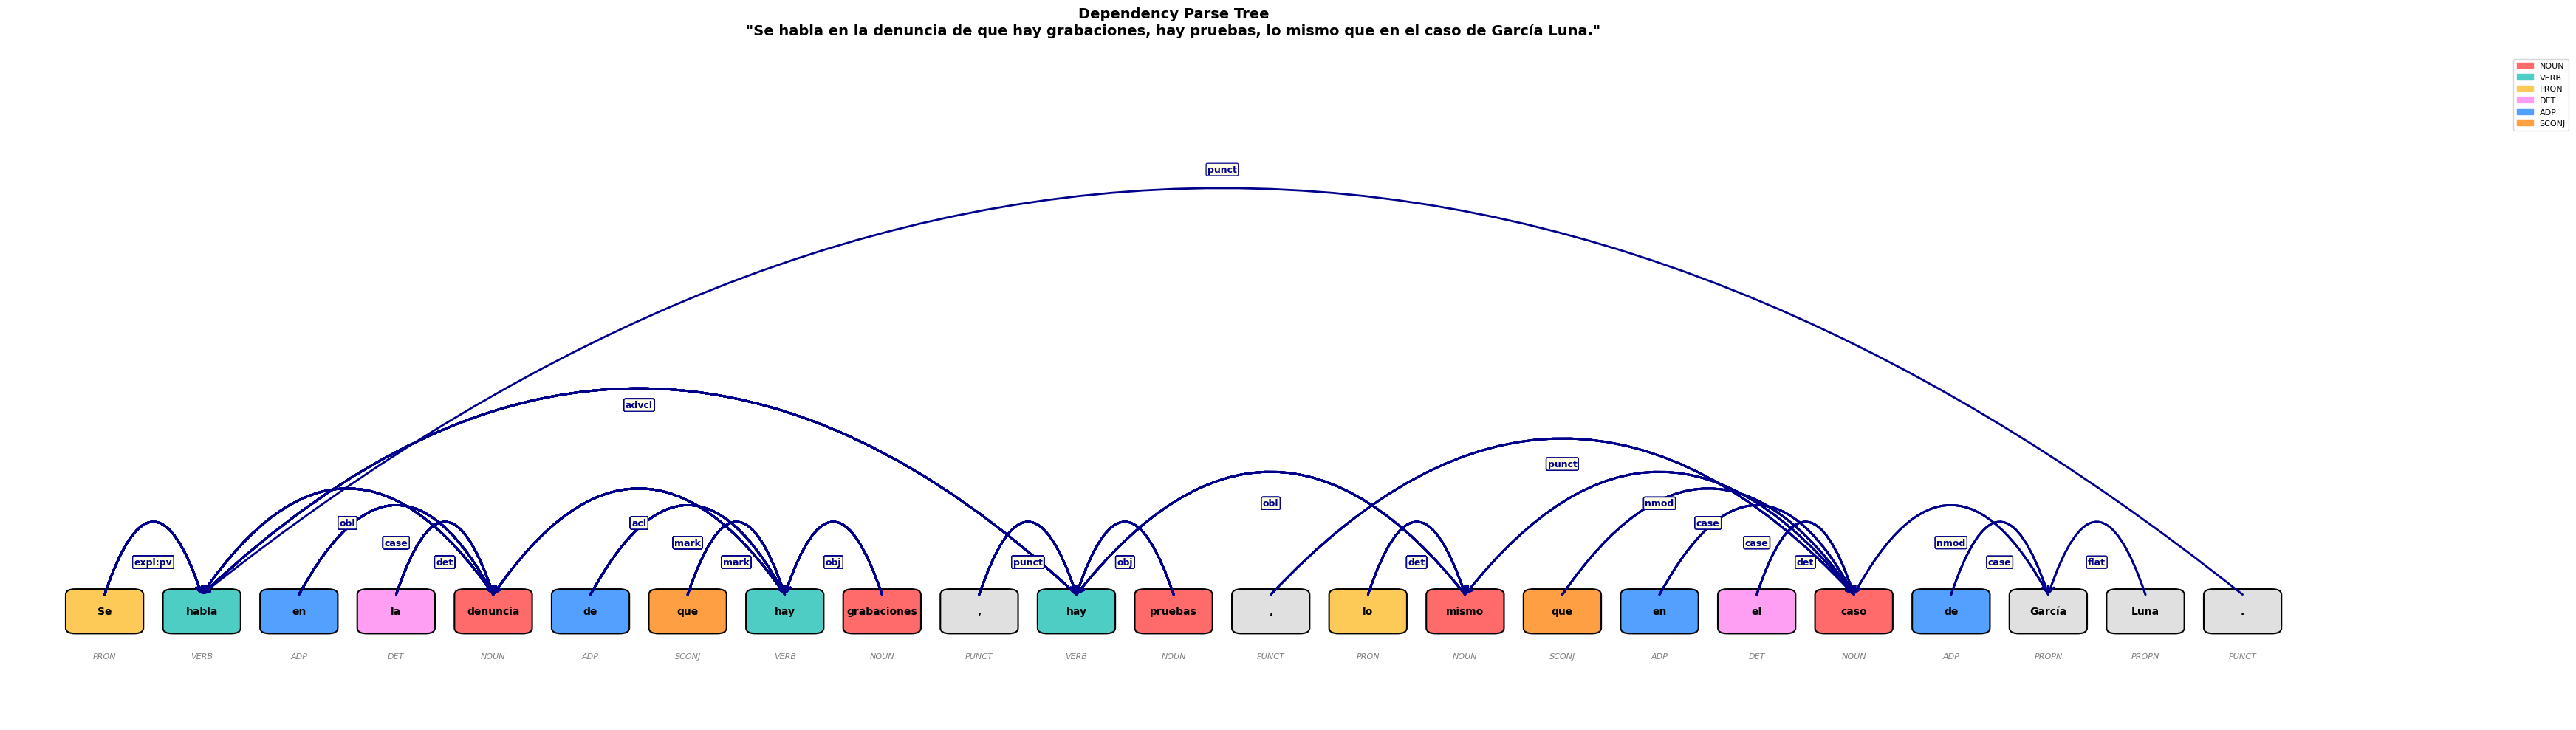

In [82]:
def visualize_dependency_tree(doc, sentence_idx=2):
    """Visualize dependency tree using NetworkX"""
    sent = doc.sentences[sentence_idx]
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes and edges
    for word in sent.words:
        G.add_node(word.id, label=f"{word.text}\n({word.pos})")
        if word.head != 0:  # Not root
            G.add_edge(word.head, word.id, label=word.deprel)
    
    # Create layout
    pos = nx.spring_layout(G, k=3, iterations=50)
    
    # Draw graph
    plt.figure(figsize=(12, 8))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=2000, alpha=0.7)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', 
                          arrows=True, arrowsize=20, arrowstyle='->')
    
    # Add node labels
    node_labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, node_labels, font_size=8)
    
    # Add edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)
    
    plt.title(f"Dependency Tree: {' '.join([w.text for w in sent.words])}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


visualize_tree_matplotlib(doc,0)